# Prerequisites

## Install libraries

In [ ]:
!pip install transformers

## Install datasets

In [ ]:
pip install datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pandas pyarrow

## Import libraries

In [ ]:
from datasets import load_dataset, Audio
from transformers import pipeline

## Download Minds14 dataset

In [ ]:
!huggingface-cli download PolyAI/minds14 --repo-type dataset --revision refs/convert/parquet --local-dir . --local-dir-use-symlinks False

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
Fetching 32 files:   0% 0/32 [00:00<?, ?it/s]downloading https://huggingface.co/datasets/PolyAI/minds14/resolve/706303078a01fcc31a36c2fc04fda5de3bdd70cf/.gitattributes to /root/.cache/huggingface/hub/tmp_hb1dfl6
downloading https://huggingface.co/datasets/PolyAI/minds14/resolve/706303078a01fcc31a36c2fc04fda5de3bdd70cf/all/train/0000.parquet to /root/.cache/huggingface/hub/tmpnkebw7p7
downloading https://huggingface.co/datasets/PolyAI/minds14/resolve/706303078a01fcc31a36c2fc04fda5de3bdd70cf/cs-CZ/train/index.duckdb to /root/.cache/huggingface/hub/tmpeetus1jp
downloading https://huggingface.co/datasets/PolyAI/minds14/resolve/706303078a01fcc31a36c2fc04fda5de3bdd70cf/de-DE/train/0000.parquet to /root/.cache/huggingface/hub/tmpvr0xvezc
downloading https://huggingface.co/datasets/PolyAI/minds14/resolve/706303078a01fcc31a36

In [ ]:
minds = load_dataset('./all', split="train")
minds = minds.cast_column('audio',Audio(sampling_rate=16_000)) # Resampling the audio to the same 16kHz rate

Generating train split: 0 examples [00:00, ? examples/s]

## Use a sample as an example

In [ ]:
sample = minds[150]
sample

{'path': '/storage/hf-datasets-cache/all/datasets/28972023612130-config-parquet-and-info-PolyAI-minds14-8a1b888c/downloads/extracted/cc95b47c127fc5de2519362996efe7cba9ffaa94cd6a98d9ecbe16c8b52f14cb/cs-CZ~PAY_BILL/response_46.wav',
 'audio': {'path': 'response_46.wav',
  'array': array([ 8.68432107e-06, -1.21098710e-05, -8.74127727e-06, ...,
          5.68924239e-04,  2.65493232e-04,  2.57359352e-05]),
  'sampling_rate': 16000},
 'transcription': 'Dobrý den já bych tě zaplatit účet prosím',
 'english_transcription': 'Hello I would pay you bill please',
 'intent_class': 13,
 'lang_id': 0}

# Text2Speech Model

## Check if GPU is available before defining the computing device

In [ ]:
import torch

device = 0 if torch.cuda.is_available() else -1

## Experiments on different Text2Speech models(Not the ones we use in our pipeline)

### Wave2vec2 English only transcription

Not used in our final pipeline since it only works with english

In [ ]:
text2speech_model = pipeline('automatic-speech-recognition',model = 'facebook/wav2vec2-base-960h',)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.masked_spec_embed']
You sho

### Whisper (Any to english transcription)

*Not used in our final pipeline

In [ ]:
text2speech_model = pipeline("automatic-speech-recognition", model="openai/whisper-small", device=device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
result = text2speech_model(sample['audio']['array'])
print(result["text"])

 I'm going to have a little party and get the film.


### Whisper (language X to language X transcription)

You need to specify the language via the language parameter

*Not used in our final pipeline since it requires to specify the language

In [ ]:
from transformers import AutoProcessor, AutoModelForSpeechSeq2Seq

processor = AutoProcessor.from_pretrained("openai/whisper-small")
model = AutoModelForSpeechSeq2Seq.from_pretrained("openai/whisper-small")
model = model.to(device)

forced_decoder_ids = processor.get_decoder_prompt_ids(language="chinese", task="transcribe")

In [ ]:
input_features = processor(sample['audio']['array'], sampling_rate=16_000, return_tensors="pt").input_features
input_features = input_features.to(device)

# generate token ids
predicted_ids = model.generate(input_features, forced_decoder_ids=forced_decoder_ids)
# decode token ids to text
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)
print(transcription[0])

我會在這裡拍片,請看我的影片


## Whisper (Any to any transcription using model weights, not  🤗 transformers)

### The version we are using in our final pipeline

### install prerequisites libraries

In [ ]:
import locale
# Set the locale to use UTF-8 encoding
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

In [ ]:
!pip install -U openai-whisper
!sudo apt update && sudo apt install ffmpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.6/798.6 kB 9.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.3 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20231117-py3-none-any.whl size=801356 sha256=002d7931e607738da96a08554b31a5f0f3f6fc7ededd0aa51616f4bc63e811b7
  Stored in directory: /root/.cache/pip/wheels/d0/85/e1/9361b4cbea7dd4b7f6702fa4c3afc94877952eeb2b62f45f56
Successfully built openai-whisper
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer

### Inference

In [ ]:
import torch
import numpy as np
import whisper

audio_data = sample['audio']['array']

if audio_data.dtype != torch.float32:
    audio_data = audio_data.astype(np.float32)

audio_tensor = torch.from_numpy(audio_data)

model = whisper.load_model("small")
result = model.transcribe(audio_tensor)
print(result["text"])

100%|███████████████████████████████████████| 461M/461M [00:14<00:00, 33.0MiB/s]


 البريا هبالتالي ه skept و كتبYA


### Checking on the original sample in the dataset

In [ ]:
print(sample['transcription'])

Dobrý den já bych tě zaplatit účet prosím


## ASR Evaluation

In [ ]:
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 20.8 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
import whisper
import jiwer

model.to(device)

# Assuming your dataset is already loaded
dataset = minds

# Initialize lists to store results
transcribed_texts = []
reference_texts = []
wers = []

# Log the total number of samples
print(f"Total number of samples in the dataset: {len(dataset)}")

for i, sample in enumerate(dataset):
    try:
        # Process audio data
        audio_data = sample['audio']['array']

        if audio_data.dtype != torch.float32:
            audio_data = audio_data.astype(np.float32)

        audio_tensor = torch.from_numpy(audio_data).to(device)

        # Perform speech recognition
        result = model.transcribe(audio_tensor)
        transcribed_text = result["text"]

        # Reference (ground truth) text
        reference_text = sample['transcription']

        # Calculate Word Error Rate (WER)
        wer = jiwer.wer(reference_text, transcribed_text)

        # Store the results
        transcribed_texts.append(transcribed_text)
        reference_texts.append(reference_text)
        wers.append(wer)

        # Log progress every 100 samples (or choose a different interval)
        if i % 100 == 0:
            print(f"Processed {i} samples...")

    except Exception as e:
        print(f"Error processing sample {i}: {e}")
        continue

# Calculate average WER
average_wer = sum(wers) / len(wers)

print(f"Average Word Error Rate (WER) across the dataset: {average_wer}")


Total number of samples in the dataset: 8168
Processed 0 samples...
Processed 100 samples...
Processed 200 samples...
Processed 300 samples...
Processed 400 samples...
Processed 500 samples...
Processed 600 samples...
Processed 700 samples...
Processed 800 samples...
Processed 900 samples...
Processed 1000 samples...
Processed 1100 samples...
Processed 1200 samples...
Processed 1300 samples...
Processed 1400 samples...
Processed 1500 samples...
Processed 1600 samples...
Processed 1700 samples...
Processed 1800 samples...
Processed 1900 samples...
Processed 2000 samples...
Processed 2100 samples...
Processed 2200 samples...
Processed 2300 samples...
Processed 2400 samples...
Processed 2500 samples...
Processed 2600 samples...
Processed 2700 samples...
Processed 2800 samples...
Processed 2900 samples...
Processed 3000 samples...
Processed 3100 samples...
Processed 3200 samples...
Processed 3300 samples...
Processed 3400 samples...
Processed 3500 samples...
Processed 3600 samples...
Proce

# Preparing data for the classifier model

In [ ]:
import pandas as pd

# Load the individual Parquet files
df1 = pd.read_parquet('/content/all/train/0000.parquet')
df2 = pd.read_parquet('/content/all/train/0001.parquet')

# Concatenate the DataFrames
merged_df = pd.concat([df1, df2], ignore_index=True)

# Save the merged DataFrame as a new Parquet file
merged_df.to_parquet('/content/drive/MyDrive/MLSP/project/merged_dataset.parquet')
minds = merged_df

### Reading the dataset

In [ ]:
import pandas as pd
df =pd.read_parquet('/content/drive/MyDrive/MLSP/project/merged_dataset.parquet')
df

,path,audio,transcription,english_transcription,intent_class,lang_id
0,/storage/hf-datasets-cache/all/datasets/289720...,{'bytes': b'RIFF\x88\xad\x00\x00WAVEfmt \x12\x...,Dobrý den potřeboval bych zjistit jaký je maxi...,"Hello, I need to find out what is the maximum ...",3,0
1,/storage/hf-datasets-cache/all/datasets/289720...,{'bytes': b'RIFF2 \x01\x00WAVEfmt \x12\x00\x00...,Dobrý den Budu si poprvé vybírat peníze z vaše...,Hello I will withdraw money from your ATM for ...,3,0
2,/storage/hf-datasets-cache/all/datasets/289720...,{'bytes': b'RIFF\x88\x85\x00\x00WAVEfmt \x12\x...,Jaký je limit který si můžu vybrat z bankomatu,What is the limit I can choose from an ATM,3,0
3,/storage/hf-datasets-cache/all/datasets/289720...,{'bytes': b'RIFFR\x91\x00\x00WAVEfmt \x12\x00\...,Kolik peněz si můžu vybrat z bankomatu,How much money can I withdraw from an ATM,3,0
4,/storage/hf-datasets-cache/all/datasets/289720...,{'bytes': b'RIFF2\x98\x01\x00WAVEfmt \x12\x00\...,Dobrý den rád bych se vás zeptal Chtěl bych si...,"Hello, I would like to ask you I would like to...",3,0
...,...,...,...,...,...,...
8163,/storage/hf-datasets-cache/all/datasets/289720...,{'bytes': b'RIFF\xde\xa2\x01\x00WAVEfmt \x12\x...,请问你能帮我把我的卡取过来吗我的卡不能够用一部能够用我的卡为什么我的卡被拒付款,Can you help me get my card? My card can’t be ...,6,13
8164,/storage/hf-datasets-cache/all/datasets/289720...,{'bytes': b'RIFF\xbc\xa2\x00\x00WAVEfmt \x12\x...,该卡无效拒绝付款,The card is invalid and the payment is declined,6,13
8165,/storage/hf-datasets-cache/all/datasets/289720...,{'bytes': b'RIFF\xdez\x00\x00WAVEfmt \x12\x00\...,卡不能用没法付款,Card cannot be used and cannot be paid,6,13
8166,/storage/hf-datasets-cache/all/datasets/289720...,{'bytes': b'RIFF\xcc\xb8\x02\x00WAVEfmt \x12\x...,你好我刚刚我刚刚使用我的银行卡进行支付可是可是怎么都付不了款然后一直显示说我的付款被拒请问一...,"Hello, I just used my bank card to make a paym...",6,13


### Shuffling and Splitting the dataset

In [ ]:
import json
import os
import torch
from sklearn.model_selection import train_test_split

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df = df[["transcription", "english_transcription", "intent_class", "lang_id"]]
# Splitting the dataset into 70% training and 30% for validation and testing
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['lang_id'], random_state=42)

# Splitting the remaining 30% equally into validation and testing
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['lang_id'], random_state=42)

print(f"Training Set: {len(train_df)}, Validation Set: {len(val_df)}, Testing Set: {len(test_df)}")


Training Set: 5717, Validation Set: 1225, Testing Set: 1226


In [ ]:
train_df

,transcription,english_transcription,intent_class,lang_id
1685,hello I was ring up to you try and transfer a ...,hello I was ring up to you try and transfer a ...,10,2
6318,Qual é a quantidade máxima de dinheiro que pos...,What is the maximum amount of money I can take...,3,11
8051,ja ich brauche meine Karte im Ausland kann ich...,"yes i need my card abroad, i can use it to pay...",0,1
1256,신규 사업 대출을 받고 싶은데요,I want to get a new business loan,5,8
7863,je voudrais pour communiquer ma nouvelle adresse,I would like to communicate my new address,1,6
...,...,...,...,...
588,Dzień dobry Chciałbym tutaj zapłacić wie pan t...,"Good morning. I would like to pay you here, yo...",10,10
5449,Dzień dobry mam pytanie Czy mógłbym użyć swoje...,"Hello, I have a question. Could I use my card ...",0,10
5486,où est la banque pour déposer de l'argent,where is the bank to deposit money,7,6
1715,hi and thank to see all my recent transactions...,hi and thank to see all my recent transactions...,12,4


### Converts dataframe into dictionary

Data is of the following format
````json5
{
  "Transcription": "",
  "English_transcription": "",
  "Intent_class": "",
  "Language_id": ""
}
````

In [ ]:
train_df_list = train_df.to_dict(orient='records')
val_df_list = val_df.to_dict(orient='records')
test_df_list = test_df.to_dict(orient='records')

test_df_list

[{'transcription': 'Добрый день Я хотел бы сегодня погасить баланс по моей кредитной карте',
  'english_transcription': 'Good afternoon. I would like to pay off my credit card balance today.',
  'intent_class': 13,
  'lang_id': 12},
 {'transcription': '在哪些国家我可以正常使用我的银行卡谢谢',
  'english_transcription': 'In which countries can I use my bank card normally? Thank you',
  'intent_class': 0,
  'lang_id': 13},
 {'transcription': '我不知道怎么代码付款用什么什么做对不起',
  'english_transcription': 'I don’t know how to code payment and what to do. Sorry',
  'intent_class': 10,
  'lang_id': 13},
 {'transcription': 'Boa tarde Gostaria de verificar Qual o saldo atual da minha conta',
  'english_transcription': 'Good afternoon I would like to check What is the current balance of my account',
  'intent_class': 4,
  'lang_id': 11},
 {'transcription': '你好我正在尝试用在线方式之所以比较大金额的款项好现在我收到了你们银行所发来的sms消息里面有付款的代码我想知道一下我要我要怎么样运用这个代码怎么样才能进行这个付款',
  'english_transcription': 'Hello. I’m trying to use the online method. The reason for 

### Encode texts from the dataset

We have to encode the texts using the tokenizer to create tensors for training the classifier.

In [ ]:
from transformers import AutoTokenizer

# Initialize the tokenizer
model_name = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def encode_texts(tokenizer, data_list):
    original_texts = [item["transcription"] for item in data_list]
    english_texts = [item.get("english_transcription", None) for item in data_list]

    # Concatenate original and English transcriptions if both are available
    texts = [f"{original} [EN] {english}" if english else original for original, english in zip(original_texts, english_texts)]

    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Now encode each dataset split
train_encoded = encode_texts(tokenizer, train_df_list)
val_encoded = encode_texts(tokenizer, val_df_list)
test_encoded = encode_texts(tokenizer, test_df_list)

train_encoded.keys()


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

### Getting Intent labels

In [ ]:
df_list = df.to_dict(orient='records')

intents = [d["intent_class"] for d in df_list]
intent_num = list(set(intents))
intent_num

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [ ]:
intent_names=[
                        "abroad",
                        "address",
                        "app_error",
                        "atm_limit",
                        "balance",
                        "business_loan",
                        "card_issues",
                        "cash_deposit",
                        "direct_debit",
                        "freeze",
                        "high_value_payment",
                        "joint_account",
                        "latest_transactions",
                        "pay_bill",
                    ]
lang_names = [
                "cs-CZ",
                "de-DE",
                "en-AU",
                "en-GB",
                "en-US",
                "es-ES",
                "fr-FR",
                "it-IT",
                "ko-KR",
                "nl-NL",
                "pl-PL",
                "pt-PT",
                "ru-RU",
                "zh-CN",

]

### Mapping intents and languages with their ID

In [ ]:
intent_map = dict() # index -> intent
for idx, ui in enumerate(intent_names):
    intent_map[ui] = idx
intent_map

encoded_intents = torch.tensor(intents)
intent_map

{'abroad': 0,
 'address': 1,
 'app_error': 2,
 'atm_limit': 3,
 'balance': 4,
 'business_loan': 5,
 'card_issues': 6,
 'cash_deposit': 7,
 'direct_debit': 8,
 'freeze': 9,
 'high_value_payment': 10,
 'joint_account': 11,
 'latest_transactions': 12,
 'pay_bill': 13}

In [ ]:
 # Creating 'class_names' from 'intent_map'
class_names = {
    0: 'abroad', 1: 'address', 2: 'app_error', 3: 'atm_limit',
    4: 'balance', 5: 'business_loan', 6: 'card_issues', 7: 'cash_deposit',
    8: 'direct_debit', 9: 'freeze', 10: 'high_value_payment',
    11: 'joint_account', 12: 'latest_transactions', 13: 'pay_bill'
}

In [ ]:
lang_map = dict() # index -> intent
for idx, ui in enumerate(lang_names):
    lang_map[ui] = idx
lang_map

{'cs-CZ': 0,
 'de-DE': 1,
 'en-AU': 2,
 'en-GB': 3,
 'en-US': 4,
 'es-ES': 5,
 'fr-FR': 6,
 'it-IT': 7,
 'ko-KR': 8,
 'nl-NL': 9,
 'pl-PL': 10,
 'pt-PT': 11,
 'ru-RU': 12,
 'zh-CN': 13}

# Classifier Model

### Language detection and translation

In [ ]:
!pip install langdetect SentencePiece sacrebleu rouge jiwer sacremoses

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from transformers import MarianMTModel, MarianTokenizer
from sacrebleu import corpus_bleu
from rouge import Rouge
from langdetect import detect
import re

def contains_chinese(text):
    """
    The model struggles to recognize chinese characters. This checks if the text contains any.
    """
    chinese_pattern = re.compile(r'[\u4e00-\u9fa5]')
    return bool(chinese_pattern.search(text))

def detect_language_and_get_id(text, target_lang="en", language_dict=lang_map):
    """
    Detect the language of the given text and return the corresponding ID from the dictionary.
    """
    try:
        # Use langdetect to detect language for most languages
        detected_lang = detect(text)

        # Special cases where langdetect's code differs from your dictionary format
        if detected_lang == 'en' and target_lang == 'en':
            return detected_lang, [2, 3, 4]  # Assign lang_ids for en-AU, en-GB, and en-US
        elif contains_chinese(text):
            detected_lang =  'zh'
            lang_code = 'zh-CN'  # Assign 'zh-CN' for Chinese text
        elif detected_lang == 'ko':
            lang_code = 'ko-KR'  # Assign 'ko-KR' for Korean
        elif detected_lang == 'cs':
            lang_code = 'cs-CZ'  # Assign 'cs-CZ' for Czech
        else:
            # Convert langdetect's language code to the format used in your dictionary
            # langdetect returns ISO 639-1 language codes (2 letters)
            lang_code = f'{detected_lang}-{detected_lang.upper()}'

        return detected_lang, [language_dict.get(lang_code, None)]
    except Exception as e:
        print(f"Language detection error: {e}")
        return None

def calculate_bleu_and_rouge(generated_texts, reference_texts):
    # Calculate BLEU score
    bleu_score = corpus_bleu(generated_texts, [reference_texts]).score

    # Calculate ROUGE score
    rouge = Rouge()
    rouge_score = rouge.get_scores(generated_texts, reference_texts, avg=True)

    return bleu_score, rouge_score


def translate_with_marianmt(text, target_lang="en"):
    """
    Translate text from the source language to the target language using MarianMT.
    """
    source_lang, lang_ids = detect_language_and_get_id(text, target_lang)

    # Handle the case where language detection fails
    if lang_ids[0] is None:
        return "Language detection failed.", None

    if source_lang == target_lang:
        return text, lang_ids

    if source_lang == "pt" and target_lang == "en":
        model_name = "Helsinki-NLP/opus-mt-ROMANCE-en"  # Example of a multilingual model
    else:
        model_name = f"Helsinki-NLP/opus-mt-{source_lang}-{target_lang}"

    # Load the tokenizer and model
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name)
    model.to(device)

    ##################################
    # Tokenize the text
    input_text = text if source_lang == "en" else f"{text}"
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    # Generate translation
    translated = model.generate(**inputs)
    translated_text = tokenizer.batch_decode(translated, skip_special_tokens=True)

    return translated_text[0], lang_ids

 # Assuming 'df' is your DataFrame with 'transcription' and 'english_transcription'
generated_translations = []
reference_translations = []

for index, row in df.iterrows():
    if index % 1000 == 0:
            print(f"Processed {index} samples...")
    translated_text, _ = translate_with_marianmt(row['transcription'], target_lang="en")
    generated_translations.append(translated_text)
    reference_translations.append(row['english_transcription'])

# Now calculate the BLEU and ROUGE scores
bleu_score, rouge_score = calculate_bleu_and_rouge(generated_translations, reference_translations)

print(f"BLEU Score: {bleu_score}")
print(f"ROUGE Score: {rouge_score}")


Processed 0 samples...


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/814k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/790k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/344M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/835k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/785k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/309M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/800k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/779k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/805k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/807k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.62M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/830k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/789k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.60M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/842k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Processed 1000 samples...
Processed 2000 samples...
Processed 3000 samples...
Processed 4000 samples...
Processed 5000 samples...
Processed 6000 samples...
Processed 7000 samples...
Processed 8000 samples...
BLEU Score: 60.71562967100448
ROUGE Score: {'rouge-1': {'r': 0.7853703373892125, 'p': 0.791730568624822, 'f': 0.7858545750102637}, 'rouge-2': {'r': 0.6537404873055993, 'p': 0.6632056877881545, 'f': 0.6561398309690228}, 'rouge-l': {'r': 0.7739251879311756, 'p': 0.7806884978526657, 'f': 0.7747367832148445}}


### Creating the model for intent classification

In [ ]:
import torch.nn as nn
from transformers import BertModel
import torch.optim as optim

class IntentClassificationModel(nn.Module):

    def __init__(self, num_labels=None, model_name=model_name, dropout_prob=0.1):
        super(IntentClassificationModel, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_prob)
        self.intent_classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, token_type_ids, attention_mask, **kwargs):
        # BERT output
        trained_bert = self.bert(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
            **kwargs
        )
        pooled_output = trained_bert['pooler_output']

        # Apply dropout
        pooled_output = self.dropout(pooled_output)

        # Intent classification
        intent_logits = self.intent_classifier(pooled_output)

        return intent_logits

# Initialize the model
intent_model = IntentClassificationModel(num_labels=len(intent_map))

### Hyperparams, Optimizer and Loss function

In [ ]:
# Define the device (CPU)
device = torch.device("cpu")

# Initialize the optimizer
opt = optim.AdamW(intent_model.parameters(), lr=3e-5, eps=1e-08)

# Define the loss function for intent classification
loss_function = nn.CrossEntropyLoss()

# Move the model to the CPU device
intent_model.to(device)


IntentClassificationModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

## Dataloader, metric functions for training

In [ ]:
pip install matplotlib seaborn


### check if gpu is available

In [ ]:
import torch
torch.cuda.is_available()


True

### importing all the needed libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, BertModel

### Creating DataLoaders

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
def create_dataloader(encoded_data, data_list, batch_size=32):
    dataset = TensorDataset(
        encoded_data['input_ids'].squeeze(),
        encoded_data['token_type_ids'].squeeze(),
        encoded_data['attention_mask'].squeeze(),
        torch.tensor([item["intent_class"] for item in data_list]),
        torch.tensor([item.get("lang_id", -1) for item in data_list])  # Handle missing lang_id
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Create DataLoaders for each dataset split
train_loader = create_dataloader(train_encoded, train_df_list)
val_loader = create_dataloader(val_encoded, val_df_list)
test_loader = create_dataloader(test_encoded, test_df_list)

### Metrics functions

In [ ]:
# Metrics computation function
def compute_metrics(true_labels, predicted_labels, num_classes):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, labels=range(num_classes), average=None, zero_division=0)
    per_intent_accuracy = []
    for i in range(num_classes):
        true_positive = sum((true_labels == i) & (predicted_labels == i))
        total = sum(true_labels == i)
        per_intent_accuracy.append(true_positive / total if total > 0 else 0)
    return accuracy, per_intent_accuracy, precision, recall, f1

# Confusion matrix plot function
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    labels = sorted(class_names, key=class_names.get)
    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=labels)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax, cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.show()

def compute_language_specific_metrics(true_labels, predicted_labels, language_ids, num_languages, num_classes):
    lang_metrics = {lang_id: {'accuracy': 0, 'precision': [0]*num_classes, 'recall': [0]*num_classes, 'f1': [0]*num_classes} for lang_id in range(num_languages)}

    for lang_id in range(num_languages):
        lang_indices = [i for i, x in enumerate(language_ids) if x == lang_id]
        if not lang_indices:
            continue
        lang_true_labels = np.array(true_labels)[lang_indices]
        lang_predicted_labels = np.array(predicted_labels)[lang_indices]

        if len(lang_true_labels) > 0:
            accuracy, _, precision, recall, f1 = compute_metrics(lang_true_labels, lang_predicted_labels, num_classes)
            lang_metrics[lang_id]['accuracy'] = accuracy
            lang_metrics[lang_id]['precision'] = precision
            lang_metrics[lang_id]['recall'] = recall
            lang_metrics[lang_id]['f1'] = f1

    return lang_metrics

## Training and Validation Loop

Epoch 1/3
Training Loss: 0.9854, Accuracy: 0.7765
Validation Loss: 0.1827, Accuracy: 0.9690
Training - Intent: abroad, Accuracy: 0.8494, Precision: 0.5972, Recall: 0.8494, F1-Score: 0.7013
Training - Intent: address, Accuracy: 0.8476, Precision: 0.9658, Recall: 0.8476, F1-Score: 0.9028
Training - Intent: app_error, Accuracy: 0.6899, Precision: 0.9261, Recall: 0.6899, F1-Score: 0.7907
Training - Intent: atm_limit, Accuracy: 0.7238, Precision: 0.9354, Recall: 0.7238, F1-Score: 0.8161
Training - Intent: balance, Accuracy: 0.7949, Precision: 0.8961, Recall: 0.7949, F1-Score: 0.8425
Training - Intent: business_loan, Accuracy: 0.8096, Precision: 0.9438, Recall: 0.8096, F1-Score: 0.8716
Training - Intent: card_issues, Accuracy: 0.6078, Precision: 0.8671, Recall: 0.6078, F1-Score: 0.7147
Training - Intent: cash_deposit, Accuracy: 0.8995, Precision: 0.4867, Recall: 0.8995, F1-Score: 0.6317
Training - Intent: direct_debit, Accuracy: 0.7091, Precision: 0.9349, Recall: 0.7091, F1-Score: 0.8065
Tra

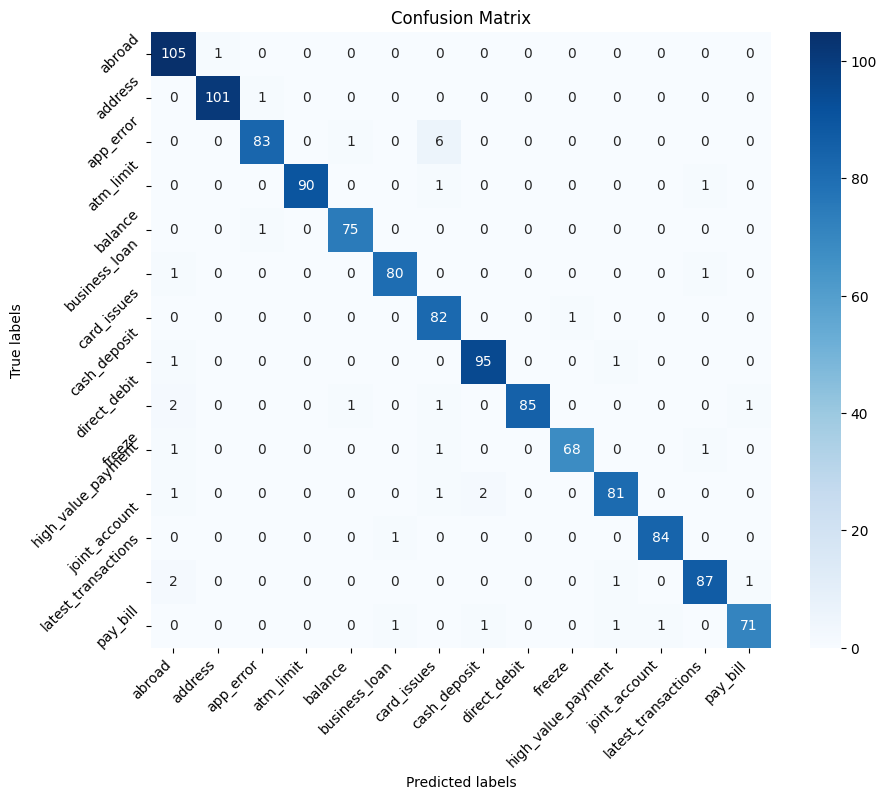

Language ID 0 - Validation Metrics: Accuracy: 0.9767
    Intent: abroad, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: address, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: app_error, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: atm_limit, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: balance, Precision: 0.8571, Recall: 1.0000, F1-Score: 0.9231
    Intent: business_loan, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: card_issues, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: cash_deposit, Precision: 0.9000, Recall: 1.0000, F1-Score: 0.9474
    Intent: direct_debit, Precision: 1.0000, Recall: 0.8000, F1-Score: 0.8889
    Intent: freeze, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: high_value_payment, Precision: 1.0000, Recall: 0.8750, F1-Score: 0.9333
    Intent: joint_account, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: latest_transactions,

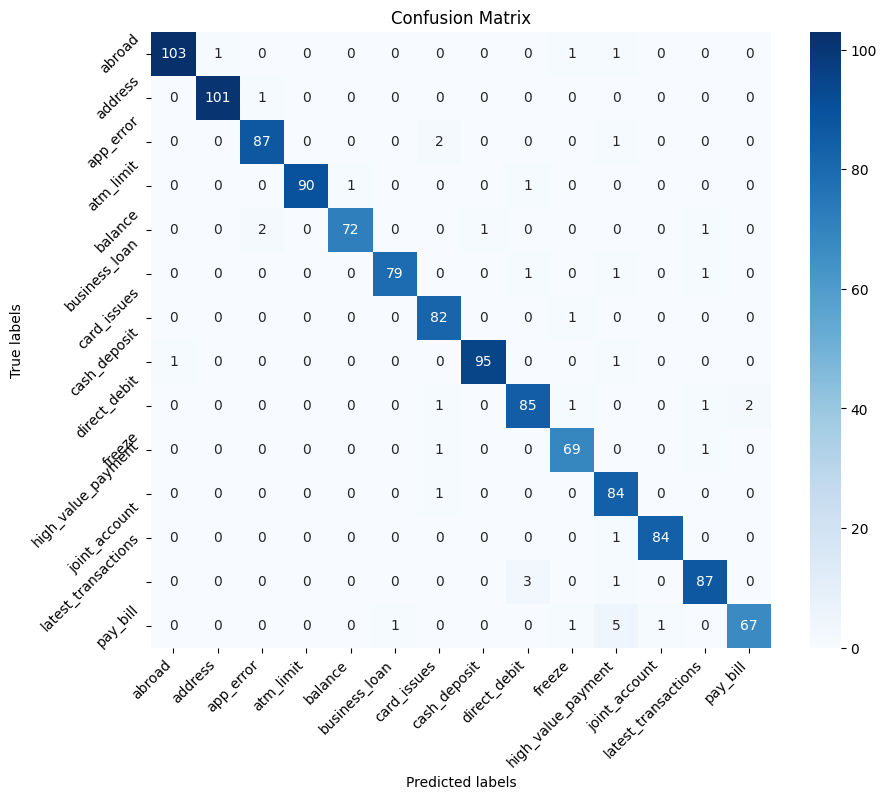

Language ID 0 - Validation Metrics: Accuracy: 1.0000
    Intent: abroad, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: address, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: app_error, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: atm_limit, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: balance, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: business_loan, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: card_issues, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: cash_deposit, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: direct_debit, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: freeze, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: high_value_payment, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: joint_account, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: latest_transactions,

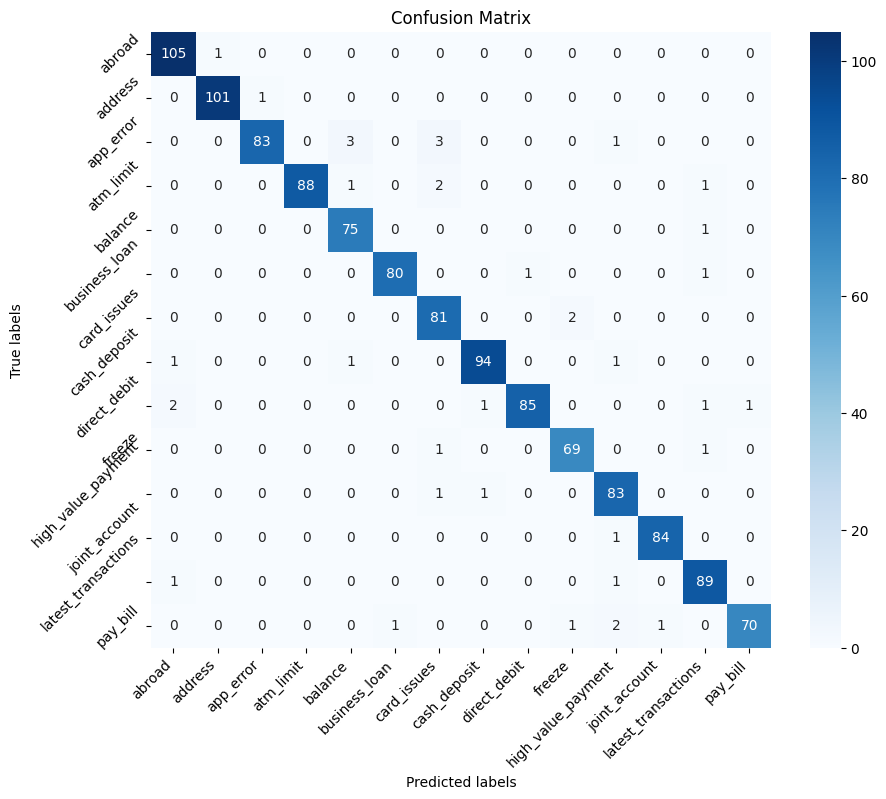

Language ID 0 - Validation Metrics: Accuracy: 1.0000
    Intent: abroad, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: address, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: app_error, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: atm_limit, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: balance, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: business_loan, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: card_issues, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: cash_deposit, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: direct_debit, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: freeze, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: high_value_payment, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: joint_account, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: latest_transactions,

In [ ]:
# Training and validation loops
num_epochs = 3
num_classes = len(intent_map)

for epoch in range(num_epochs):

    # Training Phase
    intent_model.train()
    total_train_loss = 0
    all_train_true_labels = []
    all_train_predicted_labels = []
    all_train_lang_ids = []

    for batch in train_loader:
        batch_input_ids, batch_token_type_ids, batch_attention_mask, batch_labels, batch_lang_ids = batch

        opt.zero_grad()
        outputs = intent_model(input_ids=batch_input_ids, token_type_ids=batch_token_type_ids, attention_mask=batch_attention_mask)
        loss = loss_function(outputs, batch_labels)
        loss.backward()
        opt.step()

        total_train_loss += loss.item()
        all_train_true_labels.extend(batch_labels.numpy())
        all_train_predicted_labels.extend(torch.argmax(outputs, dim=1).numpy())
        all_train_lang_ids.extend(batch_lang_ids.numpy())

    # Validation Phase
    intent_model.eval()
    total_val_loss = 0
    all_val_true_labels = []
    all_val_predicted_labels = []
    all_val_lang_ids = []

    with torch.no_grad():
        for batch in val_loader:
            batch_input_ids, batch_token_type_ids, batch_attention_mask, batch_labels, batch_lang_ids = batch

            outputs = intent_model(input_ids=batch_input_ids, token_type_ids=batch_token_type_ids, attention_mask=batch_attention_mask)
            loss = loss_function(outputs, batch_labels)

            total_val_loss += loss.item()
            all_val_true_labels.extend(batch_labels.numpy())
            all_val_predicted_labels.extend(torch.argmax(outputs, dim=1).numpy())
            all_val_lang_ids.extend(batch_lang_ids.numpy())


    # Compute and display metrics for Training and Validation
    train_accuracy, train_per_intent_accuracy, train_precision, train_recall, train_f1 = compute_metrics(np.array(all_train_true_labels), np.array(all_train_predicted_labels), num_classes)
    val_accuracy, val_per_intent_accuracy, val_precision, val_recall, val_f1 = compute_metrics(np.array(all_val_true_labels), np.array(all_val_predicted_labels), num_classes)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Training Loss: {total_train_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {total_val_loss / len(val_loader):.4f}, Accuracy: {val_accuracy:.4f}")
    # Add print statements for per-intent metrics here, if needed
    # Display per-intent metrics for Training
    for i, intent in class_names.items():
        print(f"Training - Intent: {intent}, Accuracy: {train_per_intent_accuracy[i]:.4f}, Precision: {train_precision[i]:.4f}, Recall: {train_recall[i]:.4f}, F1-Score: {train_f1[i]:.4f}")

    # Display Per-Intent Metrics for Validation
    for i, intent in class_names.items():
        print(f"Validation - Intent: {intent}, Accuracy: {val_per_intent_accuracy[i]:.4f}, Precision: {val_precision[i]:.4f}, Recall: {val_recall[i]:.4f}, F1-Score: {val_f1[i]:.4f}")

    plot_confusion_matrix(all_val_true_labels, all_val_predicted_labels, class_names)

    # Compute and display language-specific metrics
    train_lang_metrics = compute_language_specific_metrics(all_train_true_labels, all_train_predicted_labels, all_train_lang_ids, len(lang_map), num_classes)
    val_lang_metrics = compute_language_specific_metrics(all_val_true_labels, all_val_predicted_labels, all_val_lang_ids, len(lang_map), num_classes)
    # Add print statements for language-specific metrics here
    # Print Language-Specific Metrics for Validation
    for lang_id, metrics in val_lang_metrics.items():
        print(f"Language ID {lang_id} - Validation Metrics: Accuracy: {metrics['accuracy']:.4f}")
        for i, intent in enumerate(class_names.values()):
            print(f"    Intent: {intent}, Precision: {metrics['precision'][i]:.4f}, Recall: {metrics['recall'][i]:.4f}, F1-Score: {metrics['f1'][i]:.4f}")


## Evaluation


Test Loss: 0.1009, Accuracy: 0.9755
Testing - Intent: abroad, Accuracy: 0.9612, Precision: 0.9340, Recall: 0.9612, F1-Score: 0.9474
Testing - Intent: address, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
Testing - Intent: app_error, Accuracy: 0.9722, Precision: 0.9859, Recall: 0.9722, F1-Score: 0.9790
Testing - Intent: atm_limit, Accuracy: 0.9881, Precision: 0.9881, Recall: 0.9881, F1-Score: 0.9881
Testing - Intent: balance, Accuracy: 0.9545, Precision: 1.0000, Recall: 0.9545, F1-Score: 0.9767
Testing - Intent: business_loan, Accuracy: 1.0000, Precision: 0.9651, Recall: 1.0000, F1-Score: 0.9822
Testing - Intent: card_issues, Accuracy: 0.9545, Precision: 0.9722, Recall: 0.9545, F1-Score: 0.9633
Testing - Intent: cash_deposit, Accuracy: 0.9903, Precision: 0.9808, Recall: 0.9903, F1-Score: 0.9855
Testing - Intent: direct_debit, Accuracy: 0.9474, Precision: 0.9600, Recall: 0.9474, F1-Score: 0.9536
Testing - Intent: freeze, Accuracy: 0.9706, Precision: 0.9706, Recal

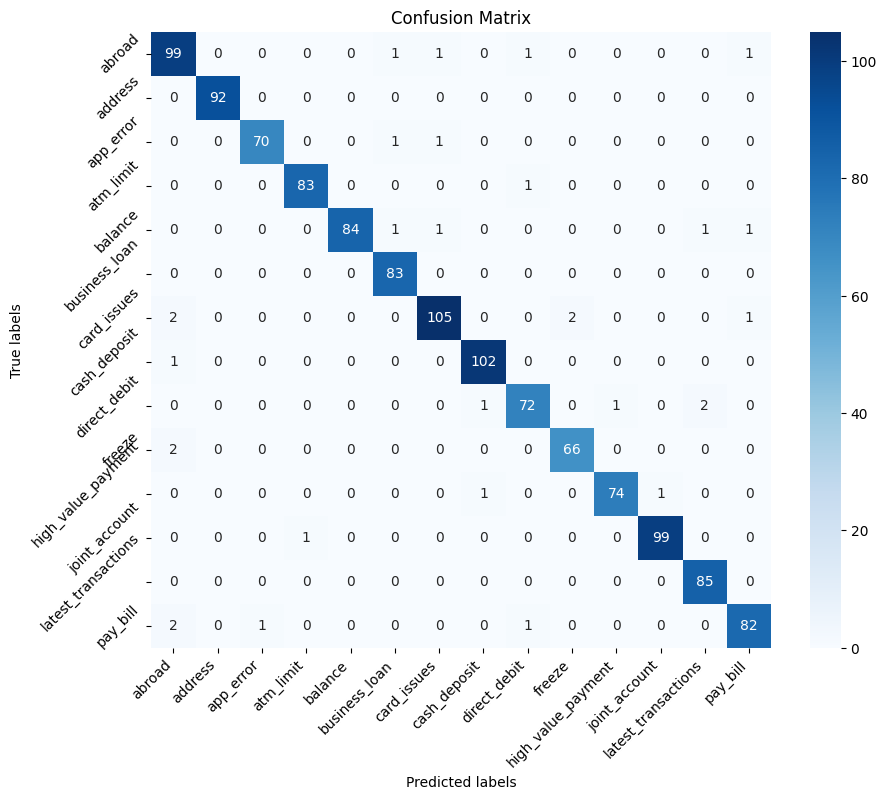

Language ID 0 - Test Metrics: Accuracy: 1.0000
    Intent: abroad, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: address, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: app_error, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: atm_limit, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: balance, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: business_loan, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: card_issues, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: cash_deposit, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: direct_debit, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: freeze, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: high_value_payment, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: joint_account, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
    Intent: latest_transactions, Preci

In [ ]:
# Testing Phase
intent_model.eval()  # Set the model to evaluation mode
total_test_loss = 0
all_test_true_labels = []
all_test_predicted_labels = []
all_test_lang_ids = []

with torch.no_grad():  # No gradients tracking
    for batch in test_loader:
        batch_input_ids, batch_token_type_ids, batch_attention_mask, batch_labels, batch_lang_ids = batch

        outputs = intent_model(input_ids=batch_input_ids, token_type_ids=batch_token_type_ids, attention_mask=batch_attention_mask)
        loss = loss_function(outputs, batch_labels)

        total_test_loss += loss.item()
        all_test_true_labels.extend(batch_labels.numpy())
        all_test_predicted_labels.extend(torch.argmax(outputs, dim=1).numpy())
        all_test_lang_ids.extend(batch_lang_ids.numpy())

# Compute and display metrics for Testing
test_accuracy, test_per_intent_accuracy, test_precision, test_recall, test_f1 = compute_metrics(np.array(all_test_true_labels), np.array(all_test_predicted_labels), num_classes)

print(f"Test Loss: {total_test_loss / len(test_loader):.4f}, Accuracy: {test_accuracy:.4f}")
# Display Per-Intent Metrics for Testing
for i, intent in class_names.items():
    print(f"Testing - Intent: {intent}, Accuracy: {test_per_intent_accuracy[i]:.4f}, Precision: {test_precision[i]:.4f}, Recall: {test_recall[i]:.4f}, F1-Score: {test_f1[i]:.4f}")

# Plot confusion matrix for Testing
plot_confusion_matrix(all_test_true_labels, all_test_predicted_labels, class_names)

# Compute and display language-specific metrics for Testing
test_lang_metrics = compute_language_specific_metrics(all_test_true_labels, all_test_predicted_labels, all_test_lang_ids, len(lang_map), num_classes)
for lang_id, metrics in test_lang_metrics.items():
    print(f"Language ID {lang_id} - Test Metrics: Accuracy: {metrics['accuracy']:.4f}")
    for i, intent in enumerate(class_names.values()):
        print(f"    Intent: {intent}, Precision: {metrics['precision'][i]:.4f}, Recall: {metrics['recall'][i]:.4f}, F1-Score: {metrics['f1'][i]:.4f}")


### Save Model and tokenizer

In [ ]:
# Save the model's state dictionary
torch.save(intent_model.state_dict(), '/content/drive/MyDrive/MLSP/project/model/intent_model.pth')

# If you also need to save the tokenizer (assuming it's from Hugging Face's Transformers)
tokenizer.save_pretrained('/content/drive/MyDrive/MLSP/project/tokenizer/')


('/content/drive/MyDrive/MLSP/project/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/MLSP/project/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/MLSP/project/tokenizer/vocab.txt',
 '/content/drive/MyDrive/MLSP/project/tokenizer/added_tokens.json',
 '/content/drive/MyDrive/MLSP/project/tokenizer/tokenizer.json')

### Loading the Model

In [ ]:
# Initialize a new instance of the model
loaded_intent_model = IntentClassificationModel(num_labels=len(intent_map))

# Load the saved state dictionary
loaded_intent_model.load_state_dict(torch.load('/content/drive/MyDrive/MLSP/project/model/intent_model.pth'))

# Ensure to call `eval()` to set dropout and batch normalization layers to evaluation mode
loaded_intent_model.eval()


IntentClassificationModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

## Inference

In [ ]:
def nlu(text, tokenizer, model, intent_names, device="cpu"):  # Change "cuda" to "cpu"
    # Extract data from the input dictionary
    english, source_id = translate_with_marianmt(text)

    # Encode the transcription text
    inputs = tokenizer(english, return_tensors="pt", padding=True)

    # Move the input tensors to the specified device
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Make predictions using the model
    with torch.no_grad():
        outputs = model(**inputs)

    # Assuming outputs is a tensor containing logits
    intent_id = torch.argmax(outputs, dim=1).item()
    predicted_intent = intent_names[intent_id]

    # Create the output information dictionary
    info = {
        "transcription": text,
        "english_transcription": english,
        "lang_id": source_id,
        "intent": predicted_intent,
    }

    return info

In [ ]:
nlu("卡不能用没法付款",tokenizer, intent_model, intent_names)


{'transcription': '卡不能用没法付款',
 'english_transcription': "The card can't be used, it can't be paid.",
 'lang_id': [13],
 'intent': 'card_issues'}